<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.1.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [3]:
data =pd.read_csv('ner_dataset.csv',encoding='latin1')
data=data.fillna(method='ffill')
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [4]:
print("Unique words in corpus:",data['Word'].nunique())
print("Unique tags in corpus:",data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [5]:
words=list(set(data['Word'].values))
words.append('ENDPAD')
num_words=len(words)

In [6]:
tags=list(set(data['Tag'].values))

num_tags=len(tags)
num_words, num_tags

(35179, 17)

### Task 3: Retrieve Sentences and Corresponsing Tags

In [7]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent=1
        self.data=data
        agg_func= lambda s: [(w, p, t) for w,p,t in zip(s["Word"].values.tolist(),s["POS"].values.tolist(),
                                                       s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
        

In [8]:
getter= SentenceGetter(data)
sentences=getter.sentences

In [9]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [11]:
word2idx= {w: i+1 for i, w in enumerate(words)}
tag2idx = {t: i for i,t in enumerate(tags)}

In [12]:
word2idx

{'investigation': 1,
 'brand-new': 2,
 'Ochami': 3,
 'Bhandara': 4,
 'Hallams': 5,
 'Brong': 6,
 'reassure': 7,
 'confined': 8,
 'Commonwealth': 9,
 'Vujadin': 10,
 'Songhua': 11,
 'Canadians': 12,
 'editions': 13,
 'Rabiah': 14,
 'Torgelow': 15,
 'Ljubotno': 16,
 'CBO': 17,
 '15-20': 18,
 'portable': 19,
 'parmesan': 20,
 '130.6': 21,
 'hers': 22,
 'Drel': 23,
 'charm': 24,
 'incorporation': 25,
 'Balochistan': 26,
 'Graz': 27,
 'politicize': 28,
 'preclude': 29,
 'deservedly': 30,
 'count': 31,
 'ILNA': 32,
 'Harare': 33,
 'misdirected': 34,
 'Fitzgerald': 35,
 'foot': 36,
 'Mombasa-based': 37,
 'pluralism': 38,
 'justly': 39,
 'Federer': 40,
 'reprocess': 41,
 '17-month': 42,
 'Nationalists': 43,
 'Wam': 44,
 'Hunan': 45,
 'long-awaited': 46,
 'retains': 47,
 'crown': 48,
 'SUU': 49,
 'anonymity': 50,
 '141.9': 51,
 'Alloceans': 52,
 'Symonds': 53,
 'optimistic': 54,
 'Cai': 55,
 'facial': 56,
 'module': 57,
 'accuse': 58,
 'crooner': 59,
 'Omdurman': 60,
 'one-meter-tall': 61,
 'Ar

### Task 5: Padding Input Sentences and Creating Train/Test Splits

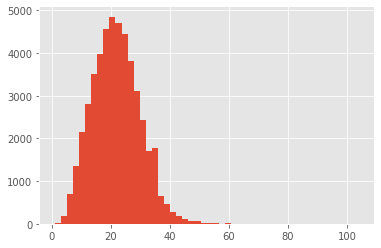

In [14]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len=50

X =[[word2idx[w[0]] for w in s ] for s in sentences]
X=pad_sequences(maxlen=max_len, sequences= X, padding='post',value=num_words-1)

y=[[tag2idx[w[2]] for w in s] for s in sentences]
y=pad_sequences(maxlen=max_len, sequences= y, padding='post',value=tag2idx['O'])
y=[to_categorical(i,num_classes= num_tags) for i in y]


In [17]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [18]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [25]:
input_word=Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
model=SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100,return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(optimizer='adam',loss= 'categorical_crossentropy', metrics=['accuracy'])

### Task 7: Train the Model

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

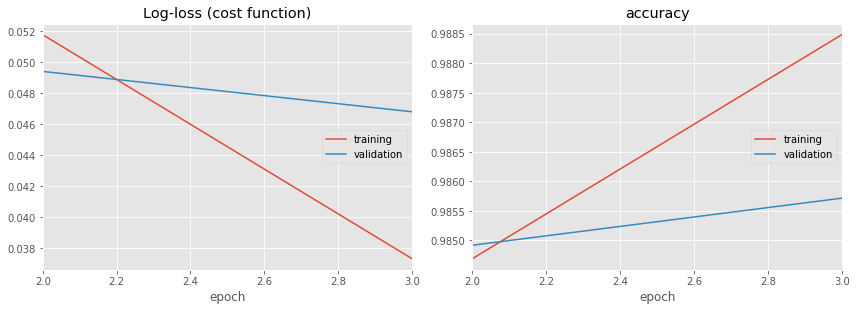

Log-loss (cost function):
training   (min:    0.037, max:    0.185, cur:    0.037)
validation (min:    0.047, max:    0.065, cur:    0.047)

accuracy:
training   (min:    0.957, max:    0.988, cur:    0.988)
validation (min:    0.981, max:    0.986, cur:    0.986)
34530/34530 [==============================] - 190s 5ms/sample - loss: 0.0373 - accuracy: 0.9885 - val_loss: 0.0468 - val_accuracy: 0.9857


In [29]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=1, verbose=0, mode='max',restore_best_weights=False)
callbacks=[PlotLossesCallback(),early_stopping]
model.fit(x_train,np.array(y_train),validation_split=0.2,
         batch_size=32,epochs=3,verbose=1,callbacks=callbacks)

### Task 8: Evaluate Named Entity Recognition Model

In [30]:
model.evaluate(x_test,np.array(y_test))

4796/4796 [==============================] - 6s 1ms/sample - loss: 0.0487 - accuracy: 0.9852


[0.048650825944565254, 0.98521686]

In [33]:
i= np.random.randint(0, x_test.shape[0])
p=model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = np.argmax(np.array(y_test),axis=-1)[i]

print("{:15}{:5}\t {}\n".format("Word","True","Pred"))
print("-"*30)
for w, true, pred in zip(x_test[i],y_true,p[0]):
    print("{:15}{:5}\t {}".format(words[w-1],tags[true],tags[pred]))

Word           True 	 Pred

------------------------------
In             O    	 O
2002           B-tim	 B-tim
,              O    	 O
they           O    	 O
were           O    	 O
charged        O    	 O
with           O    	 O
crimes         O    	 O
against        O    	 O
humanity       O    	 O
to             O    	 O
prevent        O    	 O
their          O    	 O
release        O    	 O
.              O    	 O
Rheinland-PfalzO    	 O
Rheinland-PfalzO    	 O
Rheinland-PfalzO    	 O
Rheinland-PfalzO    	 O
Rheinland-PfalzO    	 O
Rheinland-PfalzO    	 O
Rheinland-PfalzO    	 O
Rheinland-PfalzO    	 O
Rheinland-PfalzO    	 O
Rheinland-PfalzO    	 O
Rheinland-PfalzO    	 O
Rheinland-PfalzO    	 O
Rheinland-PfalzO    	 O
Rheinland-PfalzO    	 O
Rheinland-PfalzO    	 O
Rheinland-PfalzO    	 O
Rheinland-PfalzO    	 O
Rheinland-PfalzO    	 O
Rheinland-PfalzO    	 O
Rheinland-PfalzO    	 O
Rheinland-PfalzO    	 O
Rheinland-PfalzO    	 O
Rheinland-PfalzO    	 O
Rheinland-PfalzO    	 O
R